# This project was developed using the following code resources

*   https://github.com/phillipi/pix2pix.
*   https://medium.com/swlh/build-a-pix2pix-gan-with-python-6db841b302c7
*   https://towardsdatascience.com/histogram-matching-ee3a67b4cbc1
*   https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6





# 1. Downloading and extracting dataset 

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [ ]:
!pip install sewar

In [ ]:
!tar -xf maps.tar.gz  

In [ ]:
import os
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import load
from matplotlib import pyplot as plt
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
import cv2
import statistics
import json
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Utility Functions


*   **KL divergence similarity score calculation**
*   **Histogram intersection**



In [ ]:
import numpy as np
def generate_histogram(img):
    if img.shape[2] == 3: # img is colorful
        gr_img = np.mean(img, axis=-1)
    else:
        gr_img = img
    gr_hist = np.zeros([256])
    
    for x_pixel in range(gr_img.shape[0]):
        for y_pixel in range(gr_img.shape[1]):
            pixel_value = int(gr_img[x_pixel, y_pixel])
            gr_hist[pixel_value] += 1
    gr_hist /= 3
    return gr_hist, gr_img

def compute_probs(hist, n=256): 
#     print('Histogram bin', len(hist))
#     print(len(hist))
    e = len(hist)+1
    p = hist/len(hist)
    return e, p
def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int
def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def histogram_intersection(target_sample, test_sample, n_bins=256):
    bins = np.ones(n_bins)
    target_sample = (target_sample)*256
    target_sample = target_sample.astype('uint8')
    tar_hist_img, tar_gr_img = generate_histogram(target_sample)
    tar_hist_img = tar_hist_img.astype('uint8')
    h1 = tar_hist_img
    h1 = h1/sum(h1)
    
    gen_sample = (test_sample)*256
    gen_sample = gen_sample.astype('uint8')
    test_hist_img, gen_gr_img = generate_histogram(gen_sample)
    test_hist_img = test_hist_img.astype('uint8')
    h2 = test_hist_img
    h2 = h2/sum(h2)

#     print_histogram(h1)
#     print_histogram(h2)
  
    sm = 0
    for i in range(len(h1)):
        sm += min(h1[i], h2[i])
    return sm

def compute_kl_divergence(target_sample, test_sample, n_bins=256): 
    
    target_sample = (target_sample)*256
    target_sample = target_sample.astype('uint8')
    tar_hist_img, tar_gr_img = generate_histogram(target_sample)
    tar_hist_img = tar_hist_img.astype('uint8')
    e, p = compute_probs(tar_hist_img, n=n_bins)
    
    gen_sample = (test_sample)*256
    gen_sample = gen_sample.astype('uint8')
    test_hist_img, gen_gr_img = generate_histogram(gen_sample)
    test_hist_img = test_hist_img.astype('uint8')
    _, q = compute_probs(test_hist_img, n=e)
    
    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

In [ ]:
def load_images(path, size=(256,512)):
    source_list, target_list = list(), list()
    for filename in listdir(path):
        img = load_img(path + filename, target_size=size)
        img_array = img_to_array(img)
        satelite_img, map_img = img_array[:, :256], img_array[:, 256:]
        source_list.append(satelite_img)
        target_list.append(map_img)
    return [asarray(source_list), asarray(target_list)]

In [ ]:
path = '/home/csuser/Md_Asifur_rahman_CSC 675/Final Project/Pix2Pix/maps/train/'
[src_images, tar_images] = load_images(path)
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)


In [ ]:
path = '/home/csuser/Md_Asifur_rahman_CSC 675/Final Project/Pix2Pix/maps/val/'
[src_images, tar_images] = load_images(path)
filename = 'maps_test_data_256.npz'
savez_compressed(filename, src_images, tar_images)

In [ ]:
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

In [ ]:
n_samples = 2
f, axs = plt.subplots(2,2,figsize=(10,10),dpi=200)
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
    plt.title("Satelite Image")
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
    plt.title("Taget map Image")
plt.show()

In [ ]:
import random
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
#     print(trainA.shape[0])
#     ix = randint(0, trainA.shape[0], n_samples)
    ix = random.sample(range(0, trainA.shape[0]), n_samples)
#     print(ix)
    X1, X2 = trainA[ix], trainB[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

def upscale_for_printing(img):
    image = (img + 1) / 2.0   
    return image
    
def calculate_performance(step, g_model, dataset, n_samples=3, baseline=False):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    
    X_realA= upscale_for_printing(X_realA)
    X_realB= upscale_for_printing(X_realB)
    X_fakeB= upscale_for_printing(X_fakeB)
   
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
   
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
        
    if baseline:
        filename1 = 'baseline_plot_%06d.png' % (step+1)
    else:
        filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    
    if baseline:
        filename2 = 'baseline_model_%06d.h5' % (step+1)
    else:
        filename2 = 'model_%06d.h5' % (step+1)
        
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

def test_model_performance(model_path, dataset, saved_to):
    n_samples = len(dataset[0])
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_realA_print= upscale_for_printing(X_realA)
    X_realB_print= upscale_for_printing(X_realB)
    
    model = load_model(model_path)
    generated_images, _ = generate_fake_samples(model, X_realA, 1)
    Out_gen_print= upscale_for_printing(generated_images)

    uqi_score = [] 
    msssim_score = []
    ssim_0_score = []
    ssim_1_score = []
    KL_div = []
    for i in range(n_samples):
        gen = Out_gen_print[i]
        tar = X_realB_print[i]
        
        KL_div.append(compute_kl_divergence(tar,gen))
        
        gen = gen.astype('uint8')
        tar = tar.astype('uint8')
        uqi_score.append(uqi(gen, tar))
        msssim_score.append(uqi(gen, tar))
        
    mean_uqi_score = statistics.mean(uqi_score)
    mean_mssim_score = statistics.mean(msssim_score)
    mean_KL = statistics.mean(KL_div)
    print("UQI Score:", mean_uqi_score)
    print("MSSIM Score:",mean_mssim_score)
    print("KL Divergence:", mean_KL)
    dict = {'uqi' : mean_uqi_score,
            'mssim' : mean_mssim_score,
            'KL':mean_KL
           }
    f = open(saved_to,"w")
    f.write(str(dict))
    f.close()
    
    print("Result saved")

def show_randomly_generated_map(dataset, n_samples, model_path):
    [X_realA, X_realB], _ = generate_real_samples(test_dataset, n_samples, 1)
    
    X_realA_print= upscale_for_printing(X_realA)
    X_realB_print= upscale_for_printing(X_realB)
    
    model = load_model(model_path)
    generated_images, _ = generate_fake_samples(model, X_realA, 1)
    Out_gen_print= upscale_for_printing(generated_images)
    
    f, axs = plt.subplots(3,3,figsize=(15,15))
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA_print[i])
        plt.title("Satelite Image")
        
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_realB_print[i])
        plt.title("Target Map Image")
        
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(Out_gen_print[i])
        plt.title("Generated Image")

# 2 Pix2Pix Model

**Encoder and Decoder function definition**

In [ ]:
def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    #------------------------------------------------------
    # --------SKIP CONNECTION------------------------------
    g = Concatenate()([g, skip_in])
    #print('Skipped connection done without error')
    # -----------------------------------------------------
    # -----------------------------------------------------
    g = Activation('relu')(g)
    return g

### 2.1 PatchGAN Discriminator

In [ ]:
def discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([in_src_image, in_target_image], patch_out)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

### 2.2 U-Net Generator

In [ ]:
def generator(image_shape=(256,256,3)):
   
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

### 2.3 CGAN

In [ ]:
def GAN(g_model, d_model, image_shape):
    # ------------------------------------------------------------
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # ------------------------------------------------------------
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, baseline=False):
    n_patch = d_model.output_shape[1]
    print(n_patch)
    trainA, trainB = dataset
    bat_per_epoch = int(len(trainA) / n_batch)
    n_steps = bat_per_epoch * n_epochs

    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        if (i+1) % (bat_per_epoch * 10) == 0:
            print('(%d)-->, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
            calculate_performance(i, g_model, dataset, baseline)

In [ ]:
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

In [ ]:
image_shape = dataset[0].shape[1:]
discriminator_model = discriminator(image_shape)
generator_model = generator(image_shape)
pix2pixGAN_model = GAN(generator_model, discriminator_model, image_shape)

In [ ]:
discriminator_model.summary()

Model: "functional_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_58 (Concatenate)    (None, 256, 256, 6)  0           input_54[0][0]                   
                                                                 input_55[0][0]                   
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 128, 128, 64) 6208        concatenate_58[0][0] 

In [ ]:
generator_model.summary()

Model: "functional_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 128, 128, 64) 3136        input_68[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_134 (LeakyReLU)     (None, 128, 128, 64) 0           conv2d_167[0][0]                 
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 64, 64, 128)  131200      leaky_re_lu_134[0][0]            
______________________________________________________________________________________

# 3 Experiment

In [ ]:
train(discriminator_model, generator_model, pix2pixGAN_model, dataset)

In [ ]:
training_data = load_real_samples('maps_256.npz')

**Number of training samples: 1096**

In [ ]:
print('Loaded', training_data[0].shape, training_data[1].shape)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
test_dataset = load_real_samples('maps_test_data_256.npz')

**Number of testing samples: 1096**

In [ ]:
print('Loaded', test_dataset[0].shape, test_dataset[1].shape)

Loaded (1098, 256, 256, 3) (1098, 256, 256, 3)


### 3.1 Similarity score on training samples

In [ ]:
print("Different similarity scores on training set:")
test_model_performance('model_109600.h5', training_data, 'similarity_score_on_training_set.txt')

Different similarity scores on training set:
UQI Score: 0.7268797759712491
MSSIM Score: 0.7268797759712491
KL Divergence: 10.892759314621467
Histogram Intersection:  0.6214018989013059
Result saved


**Random samples from the training set for Perceptual Validation**

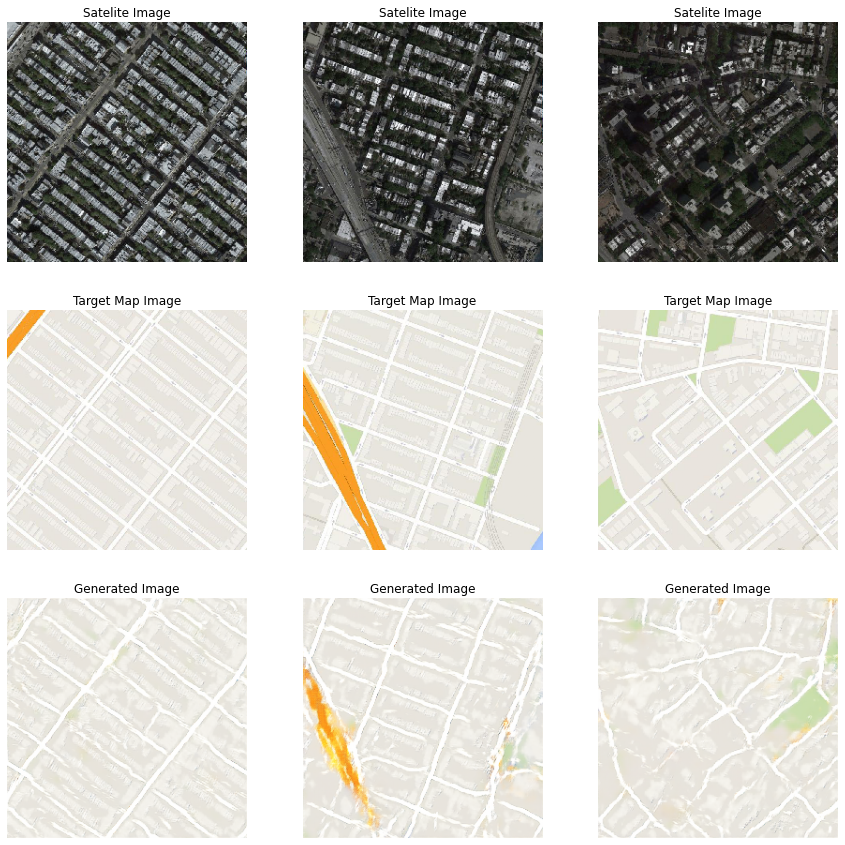

In [ ]:
show_randomly_generated_map(training_data, 3, 'model_109600.h5')

### 3.2 Similarity score on testing samples

In [ ]:
print("Different similarity scores on testing set:")
test_model_performance('model_109600.h5', test_dataset, 'similarity_score_on_testing_set.txt')

Different similarity scores on testing set:
UQI Score: 0.6916066653653233
MSSIM Score: 0.6916066653653233
KL Divergence: 12.545960281972013
Histogram Intersection:  0.6127873273232616
Result saved


**Random samples from the testing set for Perceptual Validation**

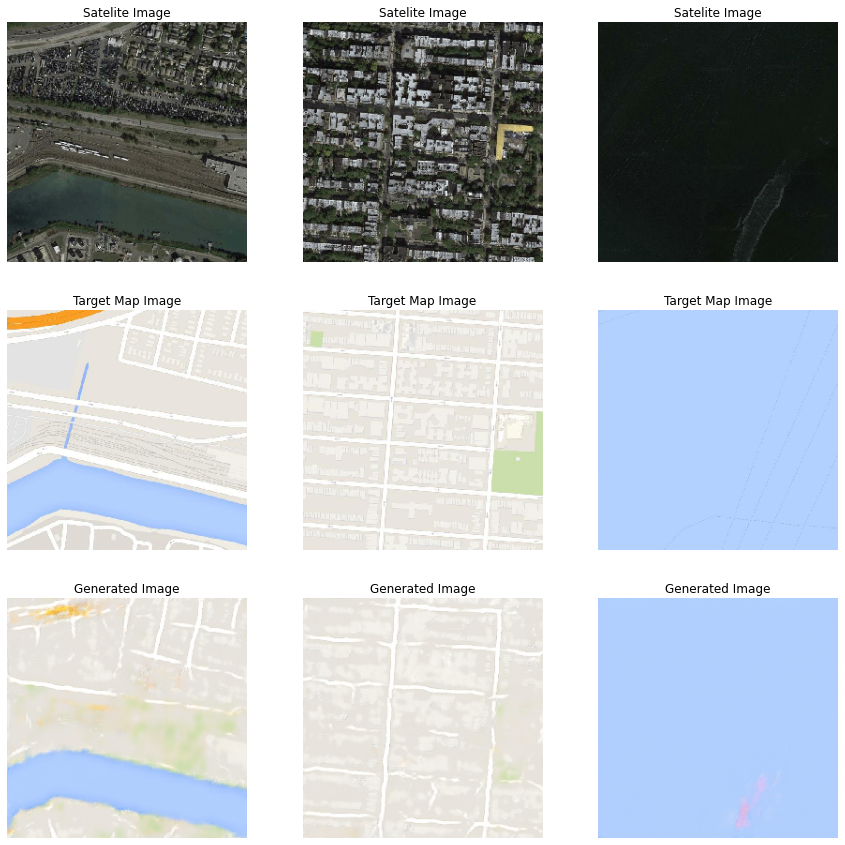

In [ ]:
show_randomly_generated_map(test_dataset, 3, 'model_109600.h5')

#4. Discussion:
To perceptually validate the performance of the developed pix2pix model 3 random samples with the corresponding generated map has been presented from both the training set and testing set. The generated maps are quite similar to the actual map however there are some visible distortions present in the generated images. Although this indicates that the trained model discussed herein has not reached the equivalent performance of the source literature, however, with more fine-tuning the hyperparameters and training we can improve its performance further. We have also used four different similarity score measurements i.e (i) Multi-scale Structural Similarity Index (MS-SSIM), (ii) Universal Image Quality Index (UQI), (iii) KL-divergence, and (iv) histogram intersection to quantify the quality of the generated image with respect to the ground truth.